In [1]:
#install dependency
# Install necessary packages with TensorFlow version 2.15.1
!pip install pandas numpy tensorflow==2.15.1 scikit-learn keras skforecast seaborn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 94.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [2]:
!pip install skforecast

# LSTM for modeling Business As Usual Condition

For simple implementation, I use a package calls skforecast, which helps with converting time series to supervised learning problem and configuring model architecture.
Following steps:
1. Grid search, random search to determine which number of lags is appropriate, as well as number of densed layers, hidden layers, recurrent units.
2. Train the model.
3. Backtesting to evaluate model's performance on test data. The test time window is determined as from 15-11-2023 to 08.01.2024 ( 1 day before the first GDL strike)
4. Run the model to find the prediction at the time window where the strike were on effect ( 10-01-2024 to 15-03-2024)
5. Calculate the mean difference and the mean percentage difference between the real observation and the 'predicted value' aka the business as usual values.

In [3]:
#import necessary packages

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


from skforecast.ForecasterRnn import ForecasterRnn
from skforecast.ForecasterRnn.utils import create_and_compile_model
from skforecast.model_selection_multiseries import backtesting_forecaster_multiseries


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter


In [4]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
from google.colab import files
uploaded = files.upload()


Saving chor_training_data.csv to chor_training_data.csv
Saving cle_training_data.csv to cle_training_data.csv
Saving rod_training_data.csv to rod_training_data.csv
Saving turi_training_data.csv to turi_training_data.csv


In [6]:
# load data
chor_training = pd.read_csv('chor_training_data.csv')
cle_training = pd.read_csv('cle_training_data.csv')
turi_training = pd.read_csv('turi_training_data.csv')
rod_training = pd.read_csv('rod_training_data.csv')



In [7]:
chor_training['Date'] = pd.to_datetime(chor_training['Date'])
cle_training['Date'] = pd.to_datetime(cle_training['Date'])
turi_training['Date'] = pd.to_datetime(turi_training['Date'])
rod_training['Date'] = pd.to_datetime(rod_training['Date'])


chor_training = chor_training.set_index('Date')
cle_training = cle_training.set_index('Date')
turi_training = turi_training.set_index('Date')
rod_training = rod_training.set_index('Date')


chor_training.index = pd.to_datetime(chor_training.index)
cle_training.index = pd.to_datetime(cle_training.index)
turi_training.index = pd.to_datetime(turi_training.index)
rod_training.index = pd.to_datetime(rod_training.index)


In [8]:
# fill missing values by interpolation
chor_training = chor_training.interpolate(method='linear')
cle_training = cle_training.interpolate(method='linear')
turi_training = turi_training.interpolate(method='linear')
rod_training = rod_training.interpolate(method='linear')




In [9]:
#drop duplicates index
chor_training = chor_training[~chor_training.index.duplicated()]
cle_training = cle_training[~cle_training.index.duplicated()]
turi_training = turi_training[~turi_training.index.duplicated()]
rod_training = rod_training[~rod_training.index.duplicated()]



In [10]:
chor_training['AQI'] = chor_training['AQI'].ffill()
cle_training['AQI'] = cle_training['AQI'].ffill()
turi_training['AQI'] = turi_training['AQI'].ffill()
rod_training['AQI'] = rod_training['AQI'].ffill()


In [11]:
AQI_chor = chor_training['AQI']
AQI_cle = cle_training['AQI']
AQI_turi = turi_training['AQI']
AQI_rod = rod_training['AQI']

#drop AQI column
chor_training = chor_training.drop(columns=['AQI','Stationscode'])
cle_training = cle_training.drop(columns=['AQI','Stationscode'])
turi_training = turi_training.drop(columns=['AQI','Stationscode'])
rod_training = rod_training.drop(columns=['AQI','Stationscode'])





In [12]:
chor_training = chor_training.resample('H').mean()
cle_training = cle_training.resample('H').mean()
turi_training = turi_training.resample('H').mean()
rod_training = rod_training.resample('H').mean()


In [13]:
chor_training = chor_training.interpolate(method='linear')
cle_training = cle_training.interpolate(method='linear')
turi_training = turi_training.interpolate(method='linear')
rod_training = rod_training.interpolate(method='linear')

In [14]:
chor_training= chor_training.dropna()

In [15]:
rod_training.interpolate(method='linear')
rod_training = rod_training.resample('H').mean()
rod_training.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19705 entries, 2022-01-01 01:00:00 to 2024-04-01 01:00:00
Freq: H
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PM_10          19705 non-null  float64
 1   NO2            19705 non-null  float64
 2   PM_2.5         11617 non-null  float64
 3   Humidity       19705 non-null  float64
 4   NO             19705 non-null  float64
 5   O3             19705 non-null  float64
 6   Temperature    19705 non-null  float64
 7   Windspeed      19705 non-null  float64
 8   WindDirection  19705 non-null  float64
 9   Precipitation  19705 non-null  float64
dtypes: float64(10)
memory usage: 1.7 MB


### Train-validation-test split

In [16]:
def train_test_split_evaluation(data):
    end_train = '2023-07-01 00:00:00'
    end_validation ='2023-11-01 00:00:00'
    end_test = '2024-01-05 00:00:00'
    data = data.loc[data.index <= end_test].copy()
    data_train = data.loc[data.index <= end_train].copy()
    data_validation = data.loc[(data.index > end_train) & (data.index <= end_validation)].copy()
    data_test = data.loc[(data.index > end_validation) & (data.index <= end_test)].copy()
    return data, data_train, data_validation, data_test


In [17]:
def train_test_split_effect_measure(data):
    end_train = '2023-11-15 00:00:00'
    end_val = '2024-01-09 00:00:00'
    end_test = '2024-03-15 00:00:00'
    data = data.loc[data.index <= end_test].copy()
    data_train = data.loc[data.index <= end_train].copy()
    data_val = data.loc[(data.index > end_train) & (data.index <= end_val)].copy()
    data_test = data.loc[(data.index > end_val) & (data.index <= end_test)].copy()
    return data, data_train, data_val, data_test

### Define models

In [18]:
from sklearn.preprocessing import MinMaxScaler


def build_model(data, series, lags, steps,epochs, batch_size,is_train):
    if is_train:
        data_final, data_train, data_val, data_test =train_test_split_evaluation(data)
    else:
        data_final, data_train, data_val, data_test =train_test_split_effect_measure(data)



    data_final = data_final[series]
    train = data_train[series]
    val = data_val[series]
    test = data_test[series]

    series = series
    levels = series[0]
    steps = steps
    lags = lags

    model = create_and_compile_model(
        series=train,
    levels=levels,
    lags=lags,
    steps=steps,
    recurrent_layer="LSTM",
    recurrent_units=[100, 50],
    dense_units=[lags*2, lags],
    activation="tanh",
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError()
)
    forecaster = ForecasterRnn(
        regressor=model,

    levels=levels,
    steps=steps,
    lags=lags,
    transformer_series=MinMaxScaler(),

    fit_kwargs={
        "epochs": epochs,
        "batch_size": batch_size,
        "series_val": val,

    },


    )
    return model,forecaster,data_final, train,val,test




In [19]:
def train_model(forecaster,train,steps):
    forecaster.fit(train)
    preds = forecaster.predict(steps=steps)
    return forecaster,preds

In [20]:
def backtesting_evaluation(forecaster,data, end_val):


    metrics, predictions = backtesting_forecaster_multiseries(
    forecaster=forecaster,
    steps=forecaster.max_step,
    series=data,
    levels=forecaster.levels,
    initial_train_size=len(data.loc[:end_val, :]),
    metric="mean_absolute_error",
    verbose=False,
    refit=False,
)


    return metrics, predictions

In [21]:
def metrics_and_plot(predictions, test):
    metrics = mean_squared_error(test, predictions)
    r2 = r2_score(test, predictions)
    plt.figure(figsize=(10, 6))
    plt.plot(test, label='True')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    plt.show()
    return metrics, r2

### Calculate Effects

In [22]:


def effect_measure(predictions, data_test, pollutant):
    # Define strike data
    strike_period_1 = pd.date_range(start='2024-02-02 03:00', end='2024-02-03 03:00', freq='H')
    strike_period_2 = pd.date_range(start='2024-02-15 03:00', end='2024-02-16 03:00', freq='H')
    strike_period_3 = pd.date_range(start='2024-02-29 03:00', end='2024-03-02 03:00', freq='H')
    strike_period_4 = pd.date_range(start='2024-03-05 03:00', end='2024-03-07 03:00', freq='H')

    all_strike_periods = strike_period_1.append(strike_period_2).append(strike_period_3).append(strike_period_4)

    strike_GDL_period_1 = pd.date_range(start='2024-01-10 02:00', end='2024-01-12 18:00', freq='H')
    strike_GDL_period_2 = pd.date_range(start='2024-01-24 02:00', end='2024-01-29 18:00', freq='H')
    strike_GDL_period_3 = pd.date_range(start='2024-03-12 02:00', end='2024-03-13 02:00', freq='H')

    strike_GDL = strike_GDL_period_1.append(strike_GDL_period_2).append(strike_GDL_period_3)

    # Calculate strike predictions and real observations
    strike_predictions = predictions.loc[all_strike_periods].copy()
    strike_real = data_test.loc[all_strike_periods].copy()

    # Mean difference and percent difference for all strike periods
    mean_diff = np.mean(strike_predictions[pollutant] - strike_real[pollutant])
    mean_percent_diff = np.mean(np.abs(strike_predictions[pollutant] - strike_real[pollutant]) /
                                ((strike_real[pollutant] + strike_predictions[pollutant]) / 2) * 100)

    print(f'Mean difference between strike prediction and real observation: {mean_diff}')
    print(f'Mean percent difference between strike prediction and real observation: {mean_percent_diff}')

    # Calculate GDL strike predictions and real observations
    strike_GDL_predictions = predictions.loc[strike_GDL].copy()
    strike_real_GDL = data_test.loc[strike_GDL].copy()

    # Mean difference and percent difference for GDL strike periods
    mean_diff_GDL = np.mean(strike_GDL_predictions[pollutant] - strike_real_GDL[pollutant])
    mean_percent_diff_GDL = np.mean(np.abs(strike_GDL_predictions[pollutant] - strike_real_GDL[pollutant]) /
                                    ((strike_real_GDL[pollutant] + strike_GDL_predictions[pollutant]) / 2) * 100)

    print(f'Mean difference between strike prediction and real observation GDL: {mean_diff_GDL}')
    print(f'Mean percent difference between strike prediction and real observation GDL: {mean_percent_diff_GDL}')

    return {
        'mean_diff': mean_diff,
        'mean_percent_diff': mean_percent_diff,
        'mean_diff_GDL': mean_diff_GDL,
        'mean_percent_diff_GDL': mean_percent_diff_GDL
    }


### PM10

#### Chorweiler

In [23]:
chor_training.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19704 entries, 2022-01-01 02:00:00 to 2024-04-01 01:00:00
Freq: H
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PM_10          19704 non-null  float64
 1   O3             19704 non-null  float64
 2   NO2            19704 non-null  float64
 3   Humidity       19704 non-null  float64
 4   NO             19704 non-null  float64
 5   Temperature    19704 non-null  float64
 6   Windspeed      19704 non-null  float64
 7   WindDirection  19704 non-null  float64
 8   Precipitation  19704 non-null  float64
dtypes: float64(9)
memory usage: 1.5 MB


In [24]:
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24

model_chor_pm10, forecaster_chor_pm10,data_chor, train_chor_pm10,val_chor_pm10,test_chor_pm10 = build_model(chor_training, series, lags, steps, 4, 128,True)

In [25]:
forecaster_chor_pm10, preds_chor_pm10 = train_model(forecaster_chor_pm10,train_chor_pm10,24)

Epoch 1/4
101/101 [==============================] - 9s 39ms/step - loss: 0.0892 - val_loss: 0.0065
Epoch 2/4
101/101 [==============================] - 2s 22ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 3/4
101/101 [==============================] - 2s 23ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 4/4
101/101 [==============================] - 2s 23ms/step - loss: 0.0045 - val_loss: 0.0062


In [ ]:
#backtesting
metrics_chor_pm10, predictions_chor_pm10 = backtesting_evaluation(forecaster_chor_pm10,data_chor, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 4s 15ms/step - loss: 5.3800e-04 - val_loss: 0.0017
Epoch 2/4
126/126 [==============================] - 1s 11ms/step - loss: 4.4008e-04 - val_loss: 7.8850e-04
Epoch 3/4
126/126 [==============================] - 2s 13ms/step - loss: 4.3903e-04 - val_loss: 0.0010
Epoch 4/4
126/126 [==============================] - 1s 11ms/step - loss: 4.6850e-04 - val_loss: 8.6035e-04


  0%|          | 0/312 [00:00<?, ?it/s]

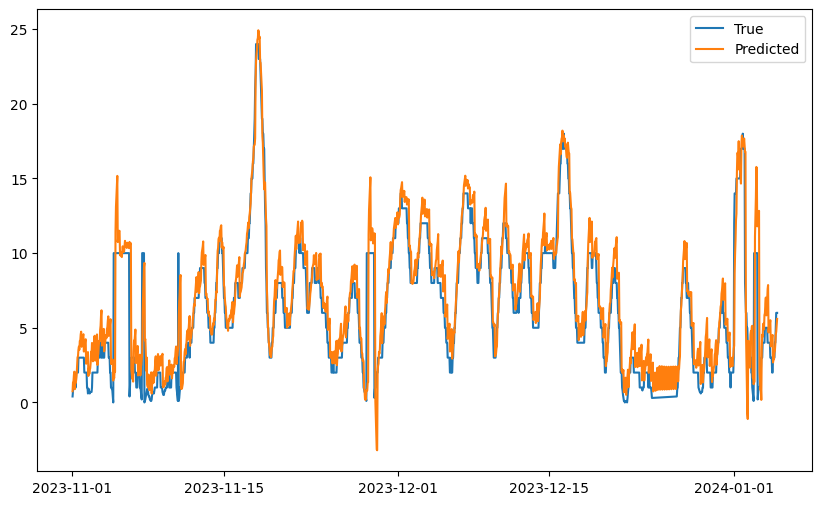

(3.624580293310098, 0.8198312671627164)

In [ ]:
metrics_and_plot(predictions_chor_pm10, test_chor_pm10['PM_10'])

In [ ]:
#train for effect measure
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24

model_chor_pm10_effect, forecaster_chor_pm10_effect,data_chor_effect, train_chor_pm10_effect,val_chor_pm10_effect,test_chor_pm10_effect = build_model(chor_training, series, lags, steps, 4, 128,False)

In [ ]:
val_chor_pm10_effect

,PM_10,Humidity,Temperature,Windspeed,WindDirection,Precipitation
Date,,,,,,
2023-11-15 01:00:00,7.0,94.2,9.7,4.7,273.0,0.0
2023-11-15 02:00:00,6.0,93.9,10.1,5.1,268.0,0.1
2023-11-15 03:00:00,6.0,93.0,10.3,5.1,268.0,0.0
2023-11-15 04:00:00,5.0,91.1,10.6,5.4,266.0,0.0
2023-11-15 05:00:00,5.0,87.6,10.8,5.9,265.0,0.1
...,...,...,...,...,...,...
2024-01-08 20:00:00,5.0,52.2,-2.7,3.0,55.0,0.0
2024-01-08 21:00:00,5.0,53.9,-3.0,2.4,61.0,0.0
2024-01-08 22:00:00,5.0,56.7,-3.3,2.1,47.0,0.0


In [ ]:
forecaster_chor_pm10_effect, preds_chor_pm10_effect = train_model(forecaster_chor_pm10_effect,train_chor_pm10_effect,24)

Epoch 1/4
126/126 [==============================] - 7s 29ms/step - loss: 0.0381 - val_loss: 0.0252
Epoch 2/4
126/126 [==============================] - 3s 25ms/step - loss: 0.0046 - val_loss: 0.0240
Epoch 3/4
126/126 [==============================] - 3s 24ms/step - loss: 0.0044 - val_loss: 0.0232
Epoch 4/4
126/126 [==============================] - 3s 22ms/step - loss: 0.0036 - val_loss: 0.0213


In [ ]:
metrics_chor_pm10_effect, predictions_chor_pm10_effect = backtesting_evaluation(forecaster_chor_pm10_effect,data_chor_effect, '2024-01-09 00:00:00')

Epoch 1/4
137/137 [==============================] - 7s 33ms/step - loss: 0.0036 - val_loss: 0.0221
Epoch 2/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0034 - val_loss: 0.0202
Epoch 3/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0034 - val_loss: 0.0199
Epoch 4/4
137/137 [==============================] - 3s 24ms/step - loss: 0.0034 - val_loss: 0.0175


  0%|          | 0/66 [00:00<?, ?it/s]

In [ ]:
predictions_chor_pm10_effect

,PM_10
2024-01-09 01:00:00,5.733382
2024-01-09 02:00:00,6.110192
2024-01-09 03:00:00,6.288692
2024-01-09 04:00:00,6.549231
2024-01-09 05:00:00,6.630980
...,...
2024-03-14 20:00:00,6.395879
2024-03-14 21:00:00,6.376263
2024-03-14 22:00:00,6.221809
2024-03-14 23:00:00,6.423785


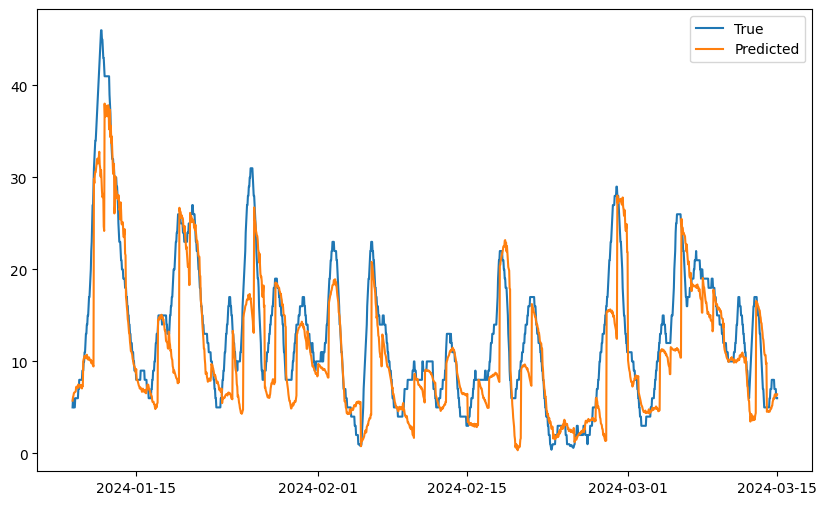

(25.337198843452562, 0.6089020346842614)

In [ ]:
metrics_and_plot(predictions_chor_pm10_effect, test_chor_pm10_effect['PM_10'])

In [ ]:
effect_measure(predictions_chor_pm10_effect, test_chor_pm10_effect,'PM_10')

Mean difference between strike prediction and real observation: -1.2408520869306616
Mean percent difference between strike prediction and real observation: 33.732052416817275
Mean difference between strike prediction and real observation GDL: -4.384429244743044
Mean percent difference between strike prediction and real observation GDL: 39.821623297927786


{'mean_diff': -1.2408520869306616,
 'mean_percent_diff': 33.732052416817275,
 'mean_diff_GDL': -4.384429244743044,
 'mean_percent_diff_GDL': 39.821623297927786}

PM_10 Clevischer

In [ ]:
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24
model_cle_pm10, forecaster_cle_pm10,data_cle, train_cle_pm10,val_cle_pm10,test_cle_pm10 = build_model(cle_training, series, lags, steps, 4, 128,True)

In [ ]:
forecaster_cle_pm10, preds_cle_pm10 = train_model(forecaster_cle_pm10,train_cle_pm10,5)

Epoch 1/4
103/103 [==============================] - 6s 19ms/step - loss: 0.0074 - val_loss: 0.0014
Epoch 2/4
103/103 [==============================] - 1s 13ms/step - loss: 7.3575e-04 - val_loss: 0.0016
Epoch 3/4
103/103 [==============================] - 1s 13ms/step - loss: 6.0060e-04 - val_loss: 6.3341e-04
Epoch 4/4
103/103 [==============================] - 1s 10ms/step - loss: 5.2950e-04 - val_loss: 5.9041e-04


In [ ]:
metrics_cle_pm10, predictions_cle_pm10 = backtesting_evaluation(forecaster_cle_pm10,data_cle, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 5s 15ms/step - loss: 4.5994e-04 - val_loss: 5.1193e-04
Epoch 2/4
126/126 [==============================] - 1s 9ms/step - loss: 3.8345e-04 - val_loss: 5.2810e-04
Epoch 3/4
126/126 [==============================] - 1s 9ms/step - loss: 3.5569e-04 - val_loss: 7.9489e-04
Epoch 4/4
126/126 [==============================] - 1s 9ms/step - loss: 4.2740e-04 - val_loss: 5.5390e-04


  0%|          | 0/312 [00:00<?, ?it/s]

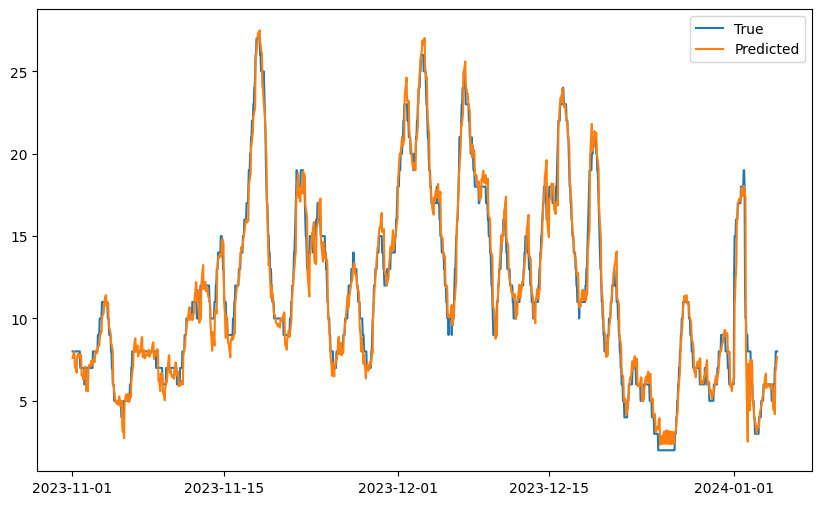

(0.954761233679027, 0.9691865756584637)

In [ ]:
metrics_and_plot(predictions_cle_pm10, test_cle_pm10['PM_10'])

In [ ]:
#effect measure
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24
model_cle_pm10_effect, forecaster_cle_pm10_effect,data_cle_effect, train_cle_pm10_effect,val_cle_pm10_effect,test_cle_pm10_effect = build_model(cle_training, series, lags, steps, 4, 128,False)

In [ ]:
forecaster_cle_pm10_effect, preds_cle_pm10_effect = train_model(forecaster_cle_pm10_effect, train_cle_pm10_effect,24)

Epoch 1/4
127/127 [==============================] - 7s 30ms/step - loss: 0.0213 - val_loss: 0.0383
Epoch 2/4
127/127 [==============================] - 3s 27ms/step - loss: 0.0044 - val_loss: 0.0773
Epoch 3/4
127/127 [==============================] - 3s 23ms/step - loss: 0.0060 - val_loss: 0.1289
Epoch 4/4
127/127 [==============================] - 3s 23ms/step - loss: 0.0067 - val_loss: 0.0263


In [ ]:
metrics_cle_pm10_effect, predictions_cle_pm10_effect = backtesting_evaluation(forecaster_cle_pm10_effect,data_cle_effect, '2024-01-09 00:00:00')

Epoch 1/4
137/137 [==============================] - 7s 34ms/step - loss: 0.0036 - val_loss: 0.0219
Epoch 2/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0034 - val_loss: 0.0270
Epoch 3/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0032 - val_loss: 0.0212
Epoch 4/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0032 - val_loss: 0.0244


  0%|          | 0/66 [00:00<?, ?it/s]

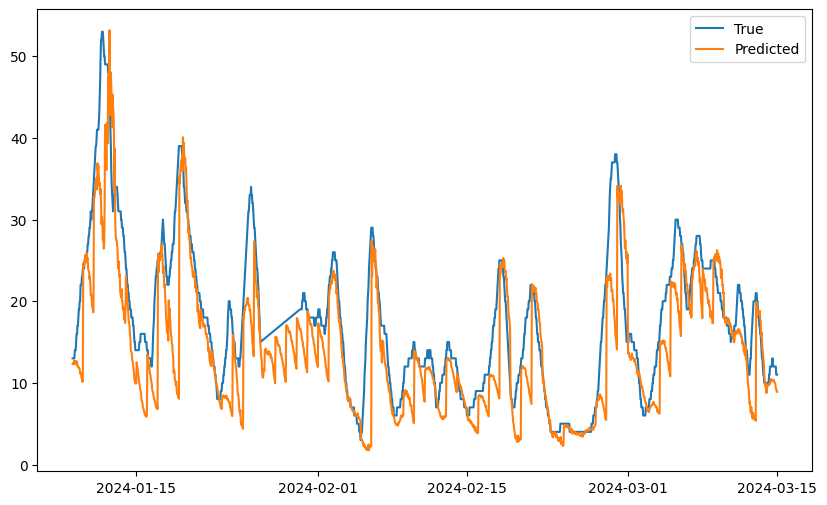

(39.947172939309134, 0.5109927548686755)

In [ ]:
metrics_and_plot(predictions_cle_pm10_effect, test_cle_pm10_effect['PM_10'])

In [ ]:
effect_measure(predictions_cle_pm10_effect, test_cle_pm10_effect,'PM_10')

Mean difference between strike prediction and real observation: -1.2864127594071466
Mean percent difference between strike prediction and real observation: 21.966584134979453
Mean difference between strike prediction and real observation GDL: -5.584776582266148
Mean percent difference between strike prediction and real observation GDL: 30.634254101129702


{'mean_diff': -1.2864127594071466,
 'mean_percent_diff': 21.966584134979453,
 'mean_diff_GDL': -5.584776582266148,
 'mean_percent_diff_GDL': 30.634254101129702}

PM_10 Turiner

In [ ]:
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24
model_turi_pm10, forecaster_turi_pm10,data_turi, train_turi_pm10,val_turi_pm10,test_turi_pm10 = build_model(turi_training, series, lags, steps, 4, 128,True)

In [ ]:
forecaster_turi_pm10, preds_turi_pm10 = train_model(forecaster_turi_pm10,train_turi_pm10,24)

Epoch 1/4
103/103 [==============================] - 6s 16ms/step - loss: 0.0078 - val_loss: 0.0010
Epoch 2/4
103/103 [==============================] - 1s 9ms/step - loss: 7.3098e-04 - val_loss: 0.0011
Epoch 3/4
103/103 [==============================] - 1s 10ms/step - loss: 5.8940e-04 - val_loss: 0.0014
Epoch 4/4
103/103 [==============================] - 1s 9ms/step - loss: 4.5849e-04 - val_loss: 5.7898e-04


In [ ]:
metrics_turi_pm10, predictions_turi_pm10 = backtesting_evaluation(forecaster_turi_pm10,data_turi, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 5s 19ms/step - loss: 4.0344e-04 - val_loss: 4.1540e-04
Epoch 2/4
126/126 [==============================] - 2s 13ms/step - loss: 3.8346e-04 - val_loss: 5.4685e-04
Epoch 3/4
126/126 [==============================] - 1s 9ms/step - loss: 3.5282e-04 - val_loss: 4.0470e-04
Epoch 4/4
126/126 [==============================] - 1s 9ms/step - loss: 3.6629e-04 - val_loss: 4.8419e-04


  0%|          | 0/312 [00:00<?, ?it/s]

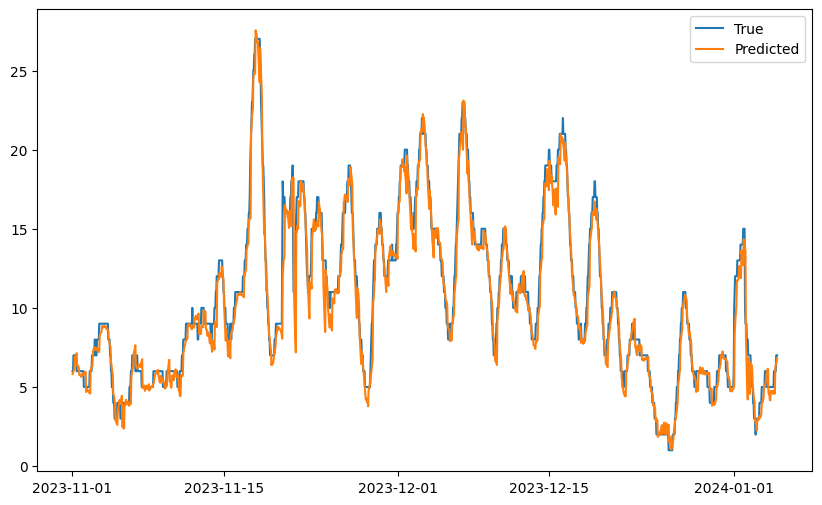

(1.078389024958076, 0.960440020657879)

In [ ]:
metrics_and_plot(predictions_turi_pm10, test_turi_pm10['PM_10'])

In [ ]:
#effect measure
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24
model_turi_pm10_effect, forecaster_turi_pm10_effect,data_turi_effect, train_turi_pm10_effect,val_turi_pm10_effect,test_turi_pm10_effect = build_model(turi_training, series, lags, steps, 4, 128,False)

In [ ]:
forecaster_turi_pm10_effect, preds_turi_pm10_effect = train_model(forecaster_turi_pm10_effect, train_turi_pm10_effect,24)

Epoch 1/4
127/127 [==============================] - 8s 32ms/step - loss: 0.0242 - val_loss: 0.0209
Epoch 2/4
127/127 [==============================] - 3s 23ms/step - loss: 0.0050 - val_loss: 0.0308
Epoch 3/4
127/127 [==============================] - 3s 23ms/step - loss: 0.0043 - val_loss: 0.0322
Epoch 4/4
127/127 [==============================] - 3s 27ms/step - loss: 0.0043 - val_loss: 0.0227


In [ ]:
metrics_turi_pm10_effect, predictions_turi_pm10_effect = backtesting_evaluation(forecaster_turi_pm10_effect,data_turi_effect, '2024-01-09 00:00:00')

Epoch 1/4
137/137 [==============================] - 7s 29ms/step - loss: 0.0034 - val_loss: 0.0204
Epoch 2/4
137/137 [==============================] - 4s 26ms/step - loss: 0.0032 - val_loss: 0.0251
Epoch 3/4
137/137 [==============================] - 3s 25ms/step - loss: 0.0032 - val_loss: 0.0147
Epoch 4/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0030 - val_loss: 0.0155


  0%|          | 0/66 [00:00<?, ?it/s]

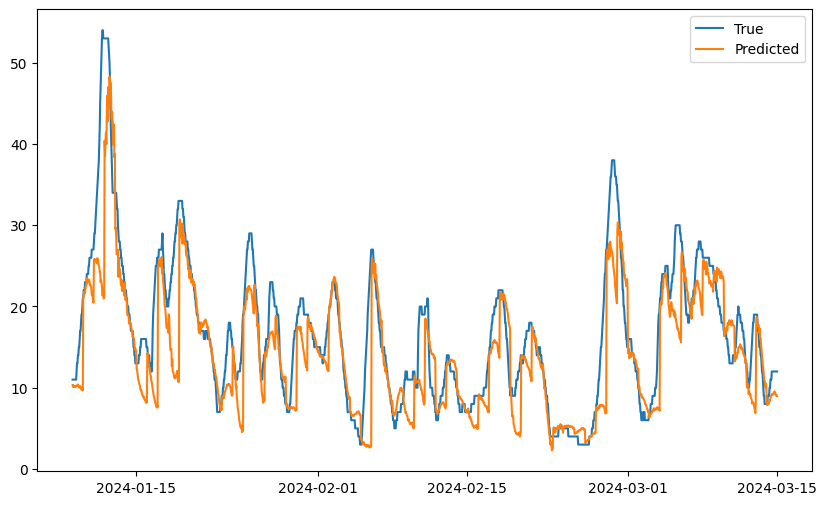

(30.820436152766344, 0.6098988800700784)

In [ ]:
metrics_and_plot(predictions_turi_pm10_effect, test_turi_pm10_effect['PM_10'])

In [ ]:
effect_measure(predictions_turi_pm10_effect, test_turi_pm10_effect,'PM_10')

Mean difference between strike prediction and real observation: -1.1535821605373073
Mean percent difference between strike prediction and real observation: 18.046526676584236
Mean difference between strike prediction and real observation GDL: -4.787152115994088
Mean percent difference between strike prediction and real observation GDL: 26.276657987845347


{'mean_diff': -1.1535821605373073,
 'mean_percent_diff': 18.046526676584236,
 'mean_diff_GDL': -4.787152115994088,
 'mean_percent_diff_GDL': 26.276657987845347}

In [ ]:
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24
model_rod_pm10, forecaster_rod_pm10,data_rod, train_rod_pm10,val_rod_pm10,test_rod_pm10 = build_model(rod_training, series, lags, steps, 4, 128,True)

In [ ]:
forecaster_rod_pm10, preds_rod_pm10 = train_model(forecaster_rod_pm10,train_rod_pm10,24)

Epoch 1/4
103/103 [==============================] - 7s 20ms/step - loss: 0.0130 - val_loss: 0.0025
Epoch 2/4
103/103 [==============================] - 1s 14ms/step - loss: 7.9449e-04 - val_loss: 9.2673e-04
Epoch 3/4
103/103 [==============================] - 1s 10ms/step - loss: 5.9262e-04 - val_loss: 9.2812e-04
Epoch 4/4
103/103 [==============================] - 1s 9ms/step - loss: 4.5374e-04 - val_loss: 7.9129e-04


In [ ]:
metrics_rod_pm10, predictions_rod_pm10 = backtesting_evaluation(forecaster_rod_pm10,data_rod, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 5s 15ms/step - loss: 4.6597e-04 - val_loss: 7.5233e-04
Epoch 2/4
126/126 [==============================] - 1s 9ms/step - loss: 3.5012e-04 - val_loss: 7.7906e-04
Epoch 3/4
126/126 [==============================] - 2s 12ms/step - loss: 3.8250e-04 - val_loss: 0.0012
Epoch 4/4
126/126 [==============================] - 1s 9ms/step - loss: 3.3120e-04 - val_loss: 9.1404e-04


  0%|          | 0/312 [00:00<?, ?it/s]

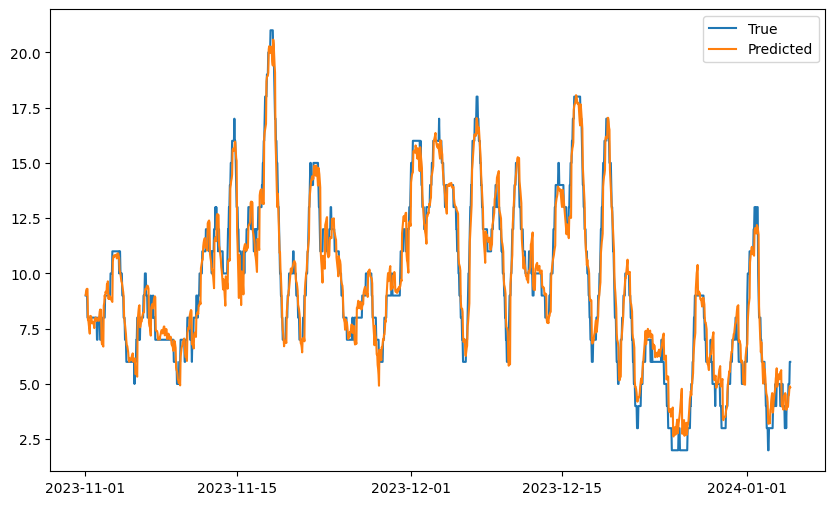

(0.7096089800441706, 0.9509983923962464)

In [ ]:
metrics_and_plot(predictions_rod_pm10, test_rod_pm10['PM_10'])

In [ ]:
#effect measure
series = ['PM_10','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24


model_rod_pm10_effect, forecaster_rod_pm10_effect,data_rod_effect, train_rod_pm10_effect,val_rod_pm10_effect,test_rod_pm10_effect = build_model(rod_training, series, lags, steps, 4, 128,False)


In [ ]:
forecaster_rod_pm10_effect, preds_rod_pm10_effect = train_model(forecaster_rod_pm10_effect,train_rod_pm10_effect,24)

Epoch 1/4
127/127 [==============================] - 8s 34ms/step - loss: 0.0286 - val_loss: 0.0288
Epoch 2/4
127/127 [==============================] - 3s 24ms/step - loss: 0.0041 - val_loss: 0.0368
Epoch 3/4
127/127 [==============================] - 3s 23ms/step - loss: 0.0039 - val_loss: 0.0211
Epoch 4/4
127/127 [==============================] - 3s 23ms/step - loss: 0.0033 - val_loss: 0.0267


In [ ]:
metrics_rod_pm10_effect, predictions_rod_pm10_effect = backtesting_evaluation(forecaster_rod_pm10_effect,data_rod_effect, '2024-01-09 00:00:00')

Epoch 1/4
137/137 [==============================] - 7s 30ms/step - loss: 0.0030 - val_loss: 0.0178
Epoch 2/4
137/137 [==============================] - 3s 25ms/step - loss: 0.0030 - val_loss: 0.0149
Epoch 3/4
137/137 [==============================] - 4s 26ms/step - loss: 0.0028 - val_loss: 0.0252
Epoch 4/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0028 - val_loss: 0.0184


  0%|          | 0/66 [00:00<?, ?it/s]

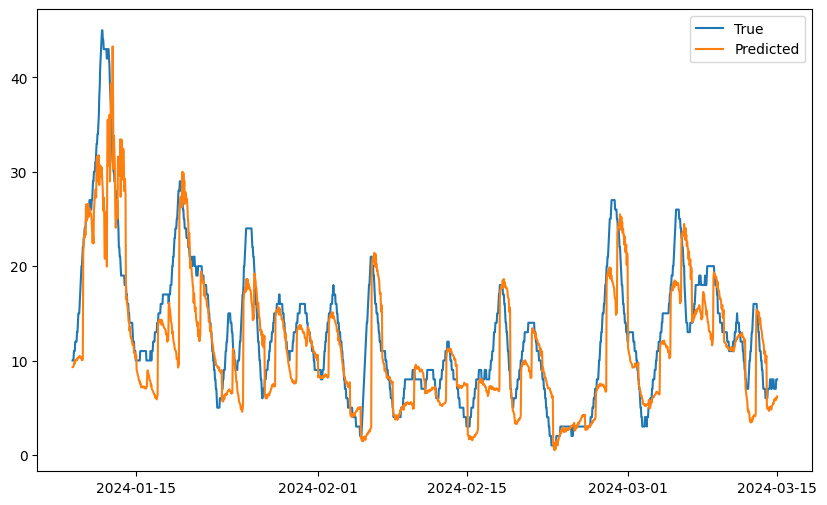

(21.64601759963031, 0.6226342403112155)

In [ ]:
metrics_and_plot(predictions_rod_pm10_effect, test_rod_pm10_effect['PM_10'])

In [ ]:
effect_measure(predictions_rod_pm10_effect, test_rod_pm10_effect,'PM_10')

Mean difference between strike prediction and real observation: -0.21754885203129537
Mean percent difference between strike prediction and real observation: 32.89305862415167
Mean difference between strike prediction and real observation GDL: -4.0094217749944345
Mean percent difference between strike prediction and real observation GDL: 33.28609498469172


{'mean_diff': -0.21754885203129537,
 'mean_percent_diff': 32.89305862415167,
 'mean_diff_GDL': -4.0094217749944345,
 'mean_percent_diff_GDL': 33.28609498469172}

No2

In [27]:
series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24

model_chor_no2, forecaster_chor_no2,data_chor, train_chor_no2,val_chor_no2,test_chor_no2 = build_model(chor_training, series, lags, steps, 4, 128,True)


In [30]:
forecaster_chor_no2, preds_chor_no2 = train_model(forecaster_chor_no2,train_chor_no2,5)

Epoch 1/4
103/103 [==============================] - 1s 10ms/step - loss: 0.0087 - val_loss: 0.0121
Epoch 2/4
103/103 [==============================] - 1s 8ms/step - loss: 0.0085 - val_loss: 0.0119
Epoch 3/4
103/103 [==============================] - 1s 8ms/step - loss: 0.0088 - val_loss: 0.0130
Epoch 4/4
103/103 [==============================] - 1s 9ms/step - loss: 0.0080 - val_loss: 0.0124


In [31]:
metrics_chor_no2, predictions_chor_no2 = backtesting_evaluation(forecaster_chor_no2,data_chor, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 4s 14ms/step - loss: 0.0079 - val_loss: 0.0104
Epoch 2/4
126/126 [==============================] - 1s 8ms/step - loss: 0.0076 - val_loss: 0.0114
Epoch 3/4
126/126 [==============================] - 1s 8ms/step - loss: 0.0073 - val_loss: 0.0109
Epoch 4/4
126/126 [==============================] - 1s 8ms/step - loss: 0.0074 - val_loss: 0.0111


  0%|          | 0/312 [00:00<?, ?it/s]

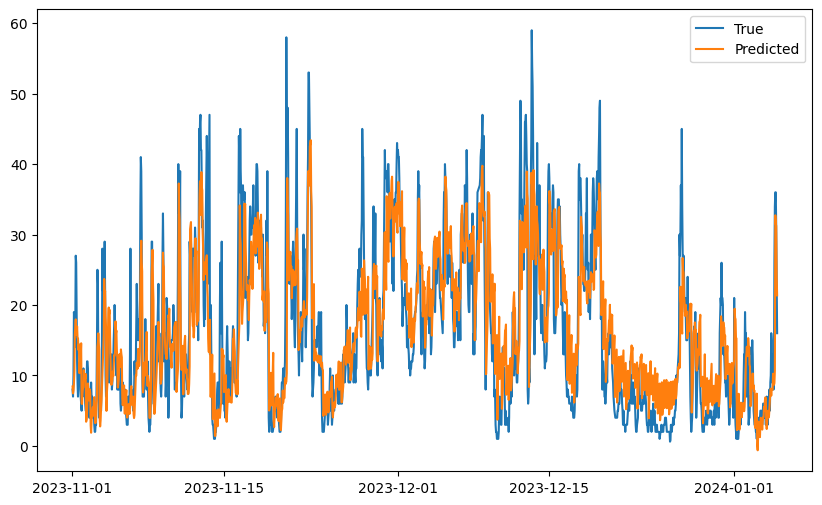

(50.85404325369805, 0.6276144766638951)

In [32]:
metrics_and_plot(predictions_chor_no2, test_chor_no2['NO2'])

Epoch 1/4
128/128 [==============================] - 8s 14ms/step - loss: 0.0266 - val_loss: 0.0268
Epoch 2/4
128/128 [==============================] - 1s 8ms/step - loss: 0.0097 - val_loss: 0.0179
Epoch 3/4
128/128 [==============================] - 1s 8ms/step - loss: 0.0089 - val_loss: 0.0182
Epoch 4/4
128/128 [==============================] - 1s 8ms/step - loss: 0.0084 - val_loss: 0.0192
Epoch 1/4
139/139 [==============================] - 7s 18ms/step - loss: 0.0083 - val_loss: 0.0179
Epoch 2/4
139/139 [==============================] - 1s 8ms/step - loss: 0.0079 - val_loss: 0.0184
Epoch 3/4
139/139 [==============================] - 1s 8ms/step - loss: 0.0078 - val_loss: 0.0182
Epoch 4/4
139/139 [==============================] - 1s 8ms/step - loss: 0.0075 - val_loss: 0.0187


  0%|          | 0/317 [00:00<?, ?it/s]

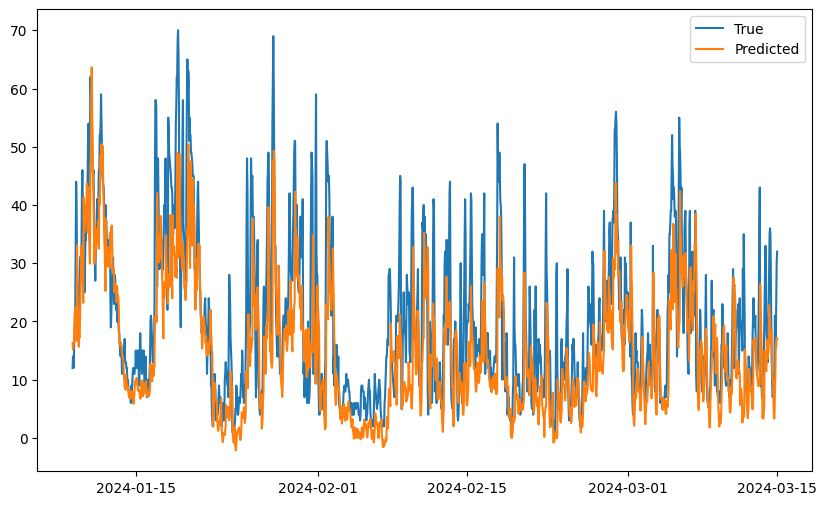

Mean difference between strike prediction and real observation: -4.1114751551602335
Mean percent difference between strike prediction and real observation: 35.812200880461894
Mean difference between strike prediction and real observation GDL: -4.936480764972481
Mean percent difference between strike prediction and real observation GDL: 57.64922147328063


{'mean_diff': -4.1114751551602335,
 'mean_percent_diff': 35.812200880461894,
 'mean_diff_GDL': -4.936480764972481,
 'mean_percent_diff_GDL': 57.64922147328063}

In [38]:

series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24

model_chor_no2_effect,forecaster_chor_no2_effect,data_chor_effect, train_chor_no2_effect,val_chor_no2_effect,test_chor_no2_effect = build_model(chor_training, series, lags, steps, 4, 128,False)
forecaster_chor_no2_effect, preds_chor_no2_effect = train_model(forecaster_chor_no2_effect,train_chor_no2_effect,5)
metrics_chor_no2_effect, predictions_chor_no2_effect = backtesting_evaluation(forecaster_chor_no2_effect,data_chor_effect, '2024-01-09 00:00:00')

metrics_and_plot(predictions_chor_no2_effect, test_chor_no2_effect['NO2'])
effect_measure(predictions_chor_no2_effect, test_chor_no2_effect,'NO2')

In [39]:
series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24
model_cle_no2, forecaster_cle_no2,data_cle, train_cle_no2,val_cle_no2,test_cle_no2 = build_model(cle_training, series, lags, steps, 4, 128,True)

In [40]:
forecaster_cle_no2, preds_cle_no2 = train_model(forecaster_cle_no2,train_cle_no2,5)

Epoch 1/4
102/102 [==============================] - 7s 17ms/step - loss: 0.0225 - val_loss: 0.0099
Epoch 2/4
102/102 [==============================] - 1s 9ms/step - loss: 0.0104 - val_loss: 0.0089
Epoch 3/4
102/102 [==============================] - 1s 9ms/step - loss: 0.0094 - val_loss: 0.0081
Epoch 4/4
102/102 [==============================] - 1s 9ms/step - loss: 0.0089 - val_loss: 0.0080


In [41]:
metrics_cle_no2, predictions_cle_no2 = backtesting_evaluation(forecaster_cle_no2,data_cle, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 5s 16ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 2/4
126/126 [==============================] - 1s 9ms/step - loss: 0.0080 - val_loss: 0.0105
Epoch 3/4
126/126 [==============================] - 1s 9ms/step - loss: 0.0080 - val_loss: 0.0137
Epoch 4/4
126/126 [==============================] - 1s 9ms/step - loss: 0.0080 - val_loss: 0.0125


  0%|          | 0/312 [00:00<?, ?it/s]

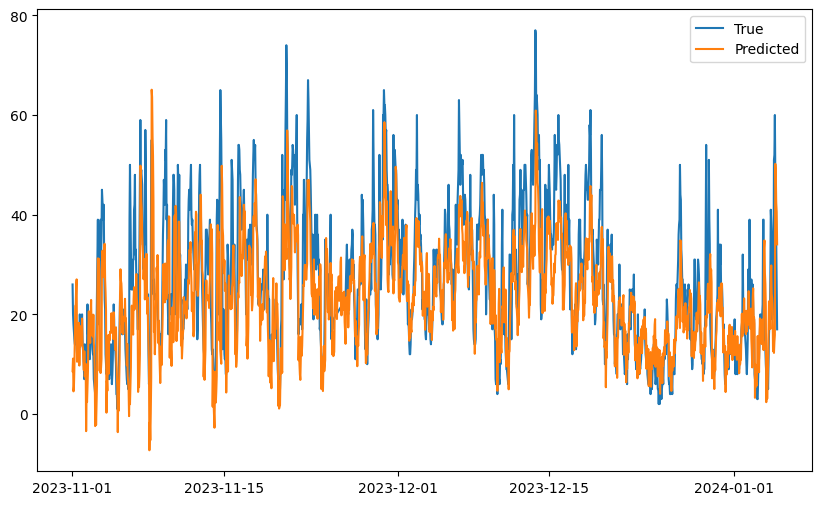

(111.25041027740417, 0.43511362310193347)

In [42]:
metrics_and_plot(predictions_cle_no2, test_cle_no2['NO2'])

Epoch 1/4
128/128 [==============================] - 5s 15ms/step - loss: 0.0176 - val_loss: 0.0250
Epoch 2/4
128/128 [==============================] - 1s 9ms/step - loss: 0.0096 - val_loss: 0.0179
Epoch 3/4
128/128 [==============================] - 1s 8ms/step - loss: 0.0088 - val_loss: 0.0195
Epoch 4/4
128/128 [==============================] - 1s 11ms/step - loss: 0.0084 - val_loss: 0.0171
Epoch 1/4
138/138 [==============================] - 4s 14ms/step - loss: 0.0076 - val_loss: 0.0166
Epoch 2/4
138/138 [==============================] - 1s 10ms/step - loss: 0.0073 - val_loss: 0.0186
Epoch 3/4
138/138 [==============================] - 2s 12ms/step - loss: 0.0072 - val_loss: 0.0152
Epoch 4/4
138/138 [==============================] - 1s 10ms/step - loss: 0.0069 - val_loss: 0.0164


  0%|          | 0/317 [00:00<?, ?it/s]

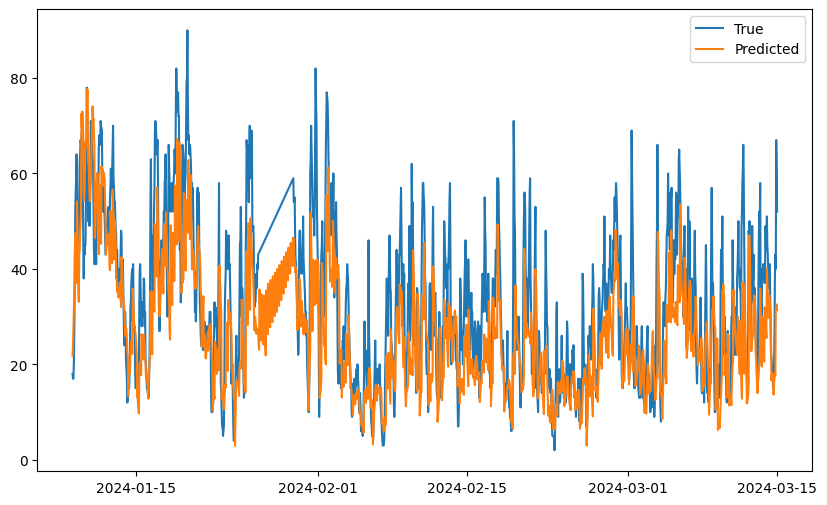

Mean difference between strike prediction and real observation: -5.565769595068854
Mean percent difference between strike prediction and real observation: 28.611635535230924
Mean difference between strike prediction and real observation GDL: -8.593653485638455
Mean percent difference between strike prediction and real observation GDL: 31.174001249156078


{'mean_diff': -5.565769595068854,
 'mean_percent_diff': 28.611635535230924,
 'mean_diff_GDL': -8.593653485638455,
 'mean_percent_diff_GDL': 31.174001249156078}

In [44]:
series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']
lags = 240
steps= 24
model_cle_no2_effect,forecaster_cle_no2_effect,data_cle_effect, train_cle_no2_effect,val_cle_no2_effect,test_cle_no2_effect = build_model(cle_training, series, lags, steps, 4, 128,False)
forecaster_cle_no2_effect, preds_cle_no2_effect = train_model(forecaster_cle_no2_effect,train_cle_no2_effect,5)
metrics_cle_no2_effect, predictions_cle_no2_effect = backtesting_evaluation(forecaster_cle_no2_effect,data_cle_effect, '2024-01-09 00:00:00')
metrics_and_plot(predictions_cle_no2_effect, test_cle_no2_effect['NO2'])
effect_measure(predictions_cle_no2_effect, test_cle_no2_effect,'NO2')

In [45]:
series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24
model_turi_no2, forecaster_turi_no2,data_turi, train_turi_no2,val_turi_no2,test_turi_no2 = build_model(turi_training, series, lags, steps, 4, 128,True)

In [46]:
forecaster_turi_no2, preds_turi_no2 = train_model(forecaster_turi_no2,train_turi_no2,5)

Epoch 1/4
102/102 [==============================] - 7s 17ms/step - loss: 0.0123 - val_loss: 0.0074
Epoch 2/4
102/102 [==============================] - 1s 9ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 3/4
102/102 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0060
Epoch 4/4
102/102 [==============================] - 1s 9ms/step - loss: 0.0047 - val_loss: 0.0056


In [47]:
metrics_turi_no2, predictions_turi_no2 = backtesting_evaluation(forecaster_turi_no2,data_turi, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 6s 21ms/step - loss: 0.0046 - val_loss: 0.0062
Epoch 2/4
126/126 [==============================] - 1s 11ms/step - loss: 0.0044 - val_loss: 0.0059
Epoch 3/4
126/126 [==============================] - 2s 16ms/step - loss: 0.0043 - val_loss: 0.0052
Epoch 4/4
126/126 [==============================] - 2s 14ms/step - loss: 0.0042 - val_loss: 0.0050


  0%|          | 0/312 [00:00<?, ?it/s]

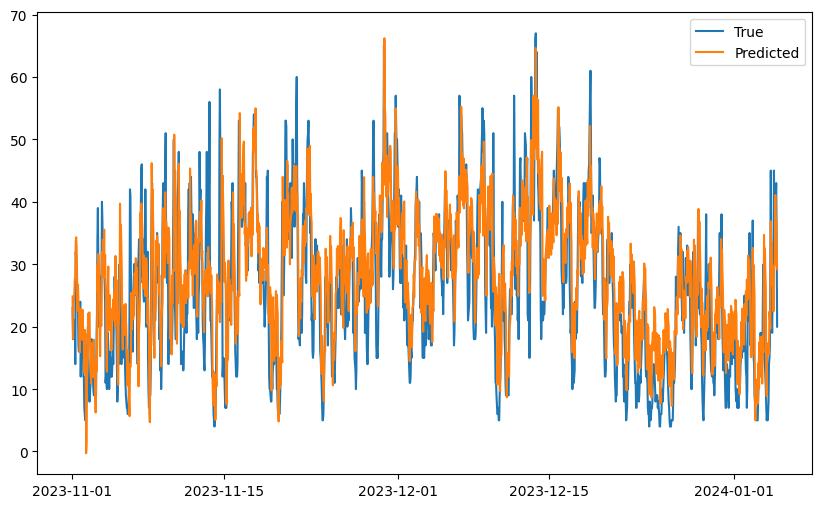

(71.68213136505081, 0.5386558573762867)

In [48]:
metrics_and_plot(predictions_turi_no2, test_turi_no2['NO2'])

Epoch 1/4
128/128 [==============================] - 8s 20ms/step - loss: 0.0176 - val_loss: 0.0318
Epoch 2/4
128/128 [==============================] - 1s 9ms/step - loss: 0.0058 - val_loss: 0.0216
Epoch 3/4
128/128 [==============================] - 1s 9ms/step - loss: 0.0050 - val_loss: 0.0218
Epoch 4/4
128/128 [==============================] - 1s 10ms/step - loss: 0.0047 - val_loss: 0.0203
Epoch 1/4
138/138 [==============================] - 4s 14ms/step - loss: 0.0044 - val_loss: 0.0269
Epoch 2/4
138/138 [==============================] - 1s 8ms/step - loss: 0.0043 - val_loss: 0.0182
Epoch 3/4
138/138 [==============================] - 1s 9ms/step - loss: 0.0042 - val_loss: 0.0215
Epoch 4/4
138/138 [==============================] - 1s 9ms/step - loss: 0.0040 - val_loss: 0.0201


  0%|          | 0/317 [00:00<?, ?it/s]

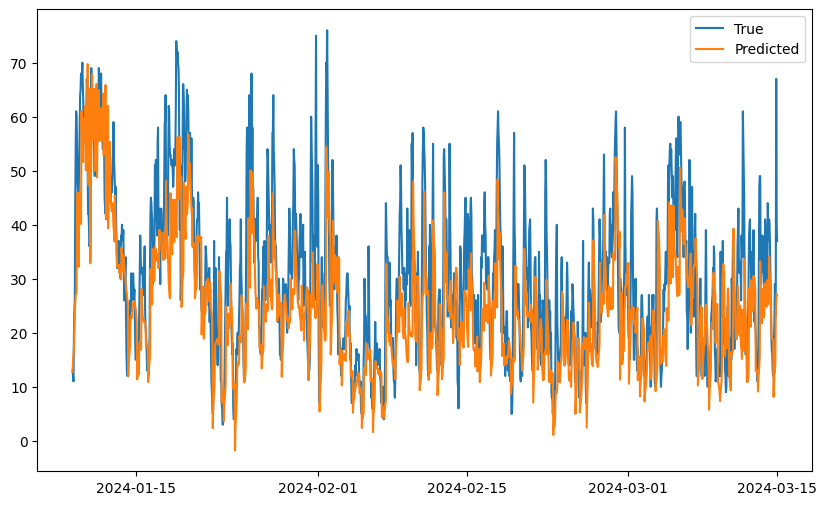

Mean difference between strike prediction and real observation: -4.510350394893337
Mean percent difference between strike prediction and real observation: 29.19803960262927
Mean difference between strike prediction and real observation GDL: -4.648946918579975
Mean percent difference between strike prediction and real observation GDL: 29.447476664049677


{'mean_diff': -4.510350394893337,
 'mean_percent_diff': 29.19803960262927,
 'mean_diff_GDL': -4.648946918579975,
 'mean_percent_diff_GDL': 29.447476664049677}

In [49]:
series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']
lags= 300
steps = 24
model_turi_no2_effect,forecaster_turi_no2_effect,data_turi_effect, train_turi_no2_effect,val_turi_no2_effect,test_turi_no2_effect = build_model(turi_training, series, lags, steps, 4, 128,False)
forecaster_turi_no2_effect, preds_turi_no2_effect = train_model(forecaster_turi_no2_effect,train_turi_no2_effect,5)
metrics_turi_no2_effect, predictions_turi_no2_effect = backtesting_evaluation(forecaster_turi_no2_effect,data_turi_effect, '2024-01-09 00:00:00')
metrics_and_plot(predictions_turi_no2_effect, test_turi_no2_effect['NO2'])
effect_measure(predictions_turi_no2_effect, test_turi_no2_effect,'NO2')

In [50]:
series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 300
steps = 24
model_rod_no2, forecaster_rod_no2,data_rod, train_rod_no2,val_rod_no2,test_rod_no2 = build_model(rod_training, series, lags, steps, 4, 128,True)

In [51]:
forecaster_rod_no2, preds_rod_no2 = train_model(forecaster_rod_no2,train_rod_no2,5)

Epoch 1/4
102/102 [==============================] - 5s 17ms/step - loss: 0.0143 - val_loss: 0.0084
Epoch 2/4
102/102 [==============================] - 1s 9ms/step - loss: 0.0054 - val_loss: 0.0073
Epoch 3/4
102/102 [==============================] - 1s 13ms/step - loss: 0.0050 - val_loss: 0.0076
Epoch 4/4
102/102 [==============================] - 1s 13ms/step - loss: 0.0046 - val_loss: 0.0068


In [52]:
metrics_rod_no2, predictions_rod_no2 = backtesting_evaluation(forecaster_rod_no2,data_rod, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 7s 26ms/step - loss: 0.0043 - val_loss: 0.0075
Epoch 2/4
126/126 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0076
Epoch 3/4
126/126 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0078
Epoch 4/4
126/126 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0062


  0%|          | 0/312 [00:00<?, ?it/s]

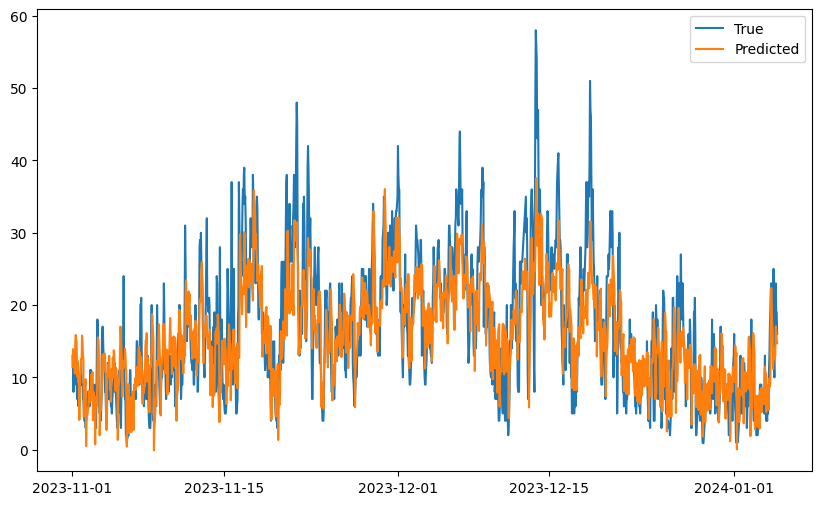

(38.41609559689418, 0.5738259841647564)

In [53]:
metrics_and_plot(predictions_rod_no2, test_rod_no2['NO2'])

Epoch 1/4
128/128 [==============================] - 6s 20ms/step - loss: 0.0119 - val_loss: 0.0257
Epoch 2/4
128/128 [==============================] - 1s 10ms/step - loss: 0.0046 - val_loss: 0.0170
Epoch 3/4
128/128 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0165
Epoch 4/4
128/128 [==============================] - 1s 9ms/step - loss: 0.0040 - val_loss: 0.0172
Epoch 1/4
138/138 [==============================] - 4s 14ms/step - loss: 0.0036 - val_loss: 0.0171
Epoch 2/4
138/138 [==============================] - 1s 10ms/step - loss: 0.0037 - val_loss: 0.0157
Epoch 3/4
138/138 [==============================] - 2s 12ms/step - loss: 0.0035 - val_loss: 0.0134
Epoch 4/4
138/138 [==============================] - 1s 10ms/step - loss: 0.0034 - val_loss: 0.0163


  0%|          | 0/317 [00:00<?, ?it/s]

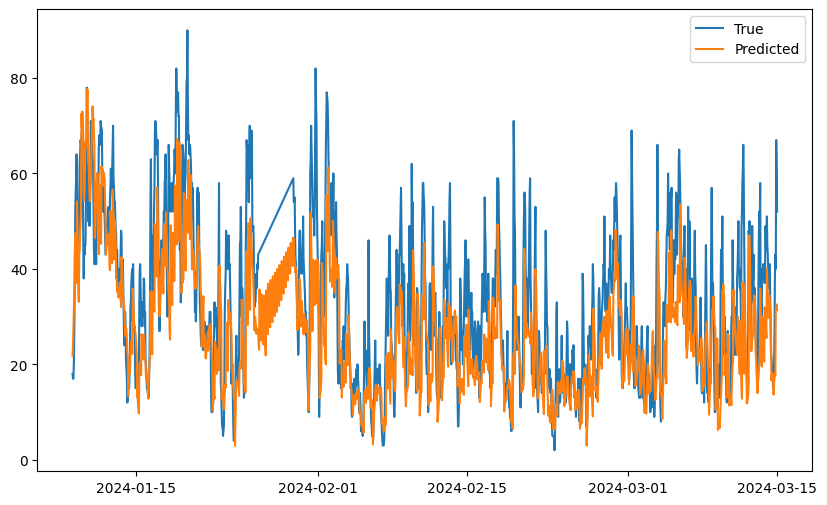

Mean difference between strike prediction and real observation: -5.121674621427381
Mean percent difference between strike prediction and real observation: 35.054017964030244
Mean difference between strike prediction and real observation GDL: -7.288191712375254
Mean percent difference between strike prediction and real observation GDL: 38.47730713175622


{'mean_diff': -5.121674621427381,
 'mean_percent_diff': 35.054017964030244,
 'mean_diff_GDL': -7.288191712375254,
 'mean_percent_diff_GDL': 38.47730713175622}

In [54]:
series = ['NO2','Humidity','Temperature','Windspeed','WindDirection','Precipitation']
lags = 300
steps = 24

model_rod_no2_effect,forecaster_rod_no2_effect,data_rod_effect, train_rod_no2_effect,val_rod_no2_effect,test_rod_no2_effect = build_model(rod_training, series, lags, steps, 4, 128,False)
forecaster_rod_no2_effect, preds_rod_no2_effect = train_model(forecaster_rod_no2_effect,train_rod_no2_effect,24)
metrics_rod_no2_effect, predictions_rod_no2_effect = backtesting_evaluation(forecaster_rod_no2_effect,data_rod_effect, '2024-01-09 00:00:00')
metrics_and_plot(predictions_cle_no2_effect, test_cle_no2_effect['NO2'])
effect_measure(predictions_rod_no2_effect, test_rod_no2_effect,'NO2')

### O3

In [ ]:
series =[ 'O3','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 240
steps = 24

model_chor_o3, forecaster_chor_o3,data_chor, train_chor_o3,val_chor_o3,test_chor_o3 = build_model(chor_training, series, lags, steps, 4, 128,True)


In [ ]:
forecaster_chor_o3, preds_chor_o3 = train_model(forecaster_chor_o3,train_chor_o3,24)

Epoch 1/4
103/103 [==============================] - 6s 16ms/step - loss: 0.0193 - val_loss: 0.0117
Epoch 2/4
103/103 [==============================] - 1s 9ms/step - loss: 0.0053 - val_loss: 0.0081
Epoch 3/4
103/103 [==============================] - 1s 9ms/step - loss: 0.0046 - val_loss: 0.0075
Epoch 4/4
103/103 [==============================] - 1s 9ms/step - loss: 0.0045 - val_loss: 0.0072


In [ ]:
metrics_chor_o3, predictions_chor_o3 = backtesting_evaluation(forecaster_chor_o3,data_chor, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 4s 15ms/step - loss: 0.0045 - val_loss: 0.0081
Epoch 2/4
126/126 [==============================] - 1s 9ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 3/4
126/126 [==============================] - 1s 11ms/step - loss: 0.0042 - val_loss: 0.0059
Epoch 4/4
126/126 [==============================] - 2s 13ms/step - loss: 0.0040 - val_loss: 0.0073


  0%|          | 0/312 [00:00<?, ?it/s]

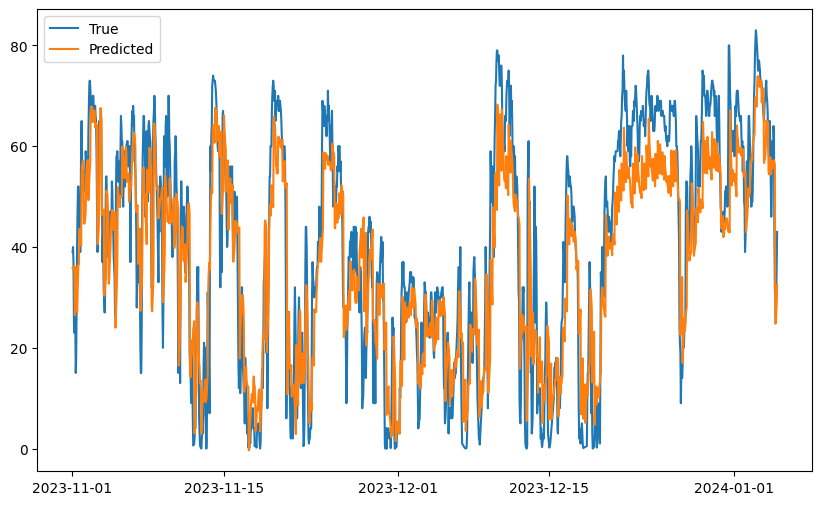

(120.45110497070358, 0.7721008946204992)

In [ ]:
metrics_and_plot(predictions_chor_o3, test_chor_o3['O3'])

In [ ]:
series = ['O3','Humidity','Temperature','Windspeed','WindDirection','Precipitation']
lags = 240
steps = 24
model_chor_o3_effect, forecaster_chor_o3_effect,data_chor_effect, train_chor_o3_effect,val_chor_o3_effect,test_chor_o3_effect = build_model(chor_training, series, lags, steps, 4, 128,False)

In [ ]:
forecast_chor_o3_effect, preds_chor_o3_effect = train_model(forecaster_chor_o3_effect,train_chor_o3_effect,24)

Epoch 1/4
126/126 [==============================] - 8s 31ms/step - loss: 0.0469 - val_loss: 0.0596
Epoch 2/4
126/126 [==============================] - 3s 22ms/step - loss: 0.0112 - val_loss: 0.0532
Epoch 3/4
126/126 [==============================] - 3s 23ms/step - loss: 0.0106 - val_loss: 0.0553
Epoch 4/4
126/126 [==============================] - 3s 24ms/step - loss: 0.0099 - val_loss: 0.0608


In [ ]:
metrics_chor_o3_effect, predictions_chor_o3_effect = backtesting_evaluation(forecaster_chor_o3_effect,data_chor_effect, '2024-01-09 00:00:00')

Epoch 1/4
137/137 [==============================] - 7s 31ms/step - loss: 0.0098 - val_loss: 0.0617
Epoch 2/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0094 - val_loss: 0.0552
Epoch 3/4
137/137 [==============================] - 3s 24ms/step - loss: 0.0091 - val_loss: 0.0529
Epoch 4/4
137/137 [==============================] - 4s 27ms/step - loss: 0.0089 - val_loss: 0.0536


  0%|          | 0/66 [00:00<?, ?it/s]

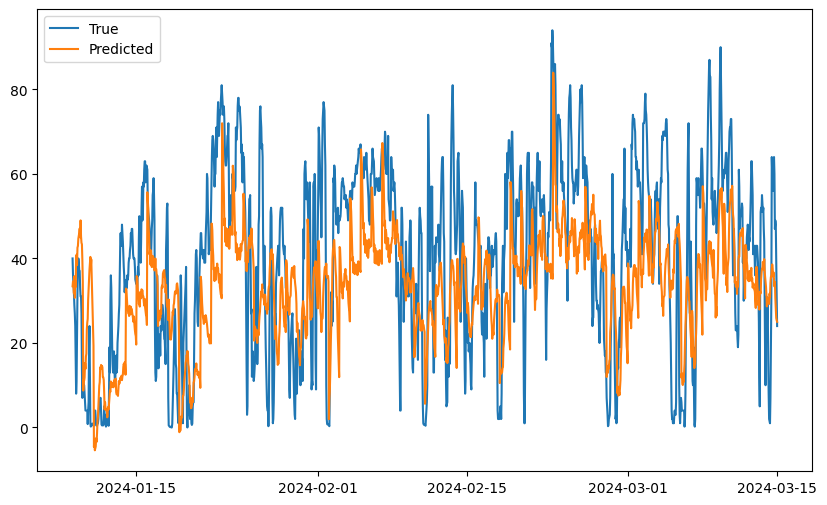

(376.1309555587535, 0.1944325549782545)

In [ ]:
metrics_and_plot(predictions_chor_o3_effect, test_chor_o3_effect['O3'])

In [ ]:
effect_measure(predictions_chor_o3_effect, test_chor_o3_effect,'O3')

Mean difference between strike prediction and real observation: -6.1904232611527314
Mean percent difference between strike prediction and real observation: 63.03101246535134
Mean difference between strike prediction and real observation GDL: -1.6788912200717672
Mean percent difference between strike prediction and real observation GDL: 47.11582179583292


{'mean_diff': -6.1904232611527314,
 'mean_percent_diff': 63.03101246535134,
 'mean_diff_GDL': -1.6788912200717672,
 'mean_percent_diff_GDL': 47.11582179583292}

In [ ]:
series =[ 'O3','Humidity','Temperature','Windspeed','WindDirection','Precipitation']

lags = 36
steps = 5

model_rod_o3, forecaster_rod_o3,data_rod, train_rod_o3,val_rod_o3,test_rod_o3 = build_model(rod_training, series, lags, steps, 4, 128,True)

In [ ]:
forecaster_rod_o3, preds_rod_o3 = train_model(forecaster_rod_o3,train_rod_o3,5)

Epoch 1/4
103/103 [==============================] - 8s 24ms/step - loss: 0.0190 - val_loss: 0.0115
Epoch 2/4
103/103 [==============================] - 1s 11ms/step - loss: 0.0067 - val_loss: 0.0110
Epoch 3/4
103/103 [==============================] - 1s 9ms/step - loss: 0.0063 - val_loss: 0.0076
Epoch 4/4
103/103 [==============================] - 1s 9ms/step - loss: 0.0057 - val_loss: 0.0075


In [ ]:
metrics_rod_o3, predictions_rod_o3 = backtesting_evaluation(forecaster_rod_o3,data_rod, '2023-11-01 00:00:00')

Epoch 1/4
126/126 [==============================] - 4s 15ms/step - loss: 0.0055 - val_loss: 0.0068
Epoch 2/4
126/126 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0068
Epoch 3/4
126/126 [==============================] - 2s 13ms/step - loss: 0.0052 - val_loss: 0.0077
Epoch 4/4
126/126 [==============================] - 2s 13ms/step - loss: 0.0050 - val_loss: 0.0062


  0%|          | 0/312 [00:00<?, ?it/s]

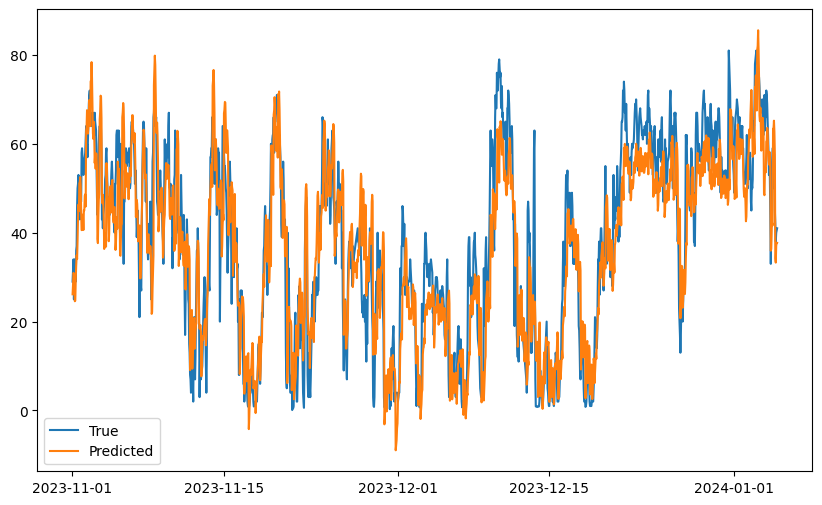

(107.69364005794151, 0.7648870782024602)

In [ ]:
metrics_and_plot(predictions_rod_o3, test_rod_o3['O3'])

In [ ]:
series = ['O3','Humidity','Temperature','Windspeed','WindDirection','Precipitation']
lags = 240
steps = 24
model_rod_o3_effect, forecaster_rod_o3_effect,data_rod_effect, train_rod_o3_effect,val_rod_o3_effect,test_rod_o3_effect = build_model(rod_training, series, lags, steps, 4, 128,False)

forecaster_rod_o3_effect, preds_rod_o3_effect = train_model(forecaster_rod_o3_effect,train_rod_o3_effect,24)

Epoch 1/4
127/127 [==============================] - 8s 33ms/step - loss: 0.0483 - val_loss: 0.0475
Epoch 2/4
127/127 [==============================] - 3s 25ms/step - loss: 0.0119 - val_loss: 0.0508
Epoch 3/4
127/127 [==============================] - 3s 23ms/step - loss: 0.0111 - val_loss: 0.0651
Epoch 4/4
127/127 [==============================] - 3s 23ms/step - loss: 0.0104 - val_loss: 0.0487


In [ ]:
metrics_rod_o3_effect, predictions_rod_o3_effect = backtesting_evaluation(forecaster_rod_o3_effect,data_rod_effect, '2024-01-09 00:00:00')

Epoch 1/4
137/137 [==============================] - 9s 30ms/step - loss: 0.0106 - val_loss: 0.0546
Epoch 2/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0094 - val_loss: 0.0557
Epoch 3/4
137/137 [==============================] - 4s 28ms/step - loss: 0.0093 - val_loss: 0.0677
Epoch 4/4
137/137 [==============================] - 3s 23ms/step - loss: 0.0091 - val_loss: 0.0680


  0%|          | 0/66 [00:00<?, ?it/s]

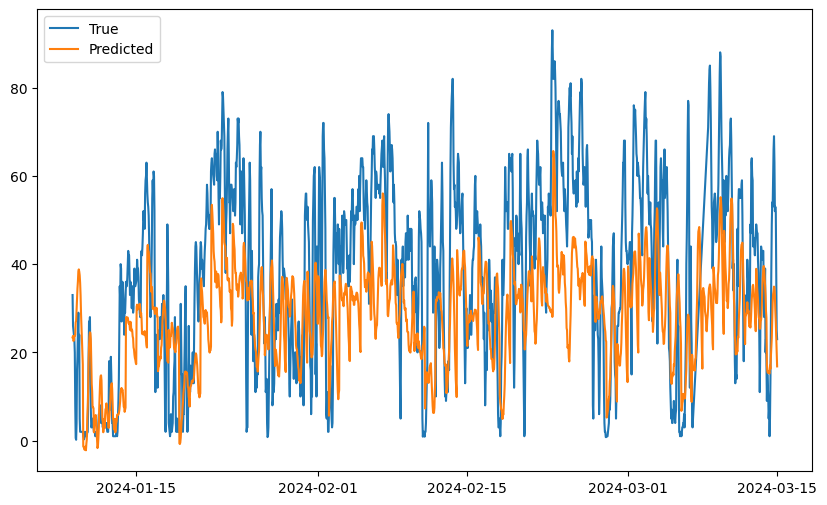

(397.1287934228631, 0.11526384589543415)

In [ ]:
metrics_and_plot(predictions_rod_o3_effect, test_rod_o3_effect['O3'])

In [ ]:
effect_measure(predictions_rod_o3_effect, test_rod_o3_effect,'O3')

Mean difference between strike prediction and real observation: -9.673113854327257
Mean percent difference between strike prediction and real observation: 64.5055487134012
Mean difference between strike prediction and real observation GDL: -4.1818786918460535
Mean percent difference between strike prediction and real observation GDL: 66.48171130945168


{'mean_diff': -9.673113854327257,
 'mean_percent_diff': 64.5055487134012,
 'mean_diff_GDL': -4.1818786918460535,
 'mean_percent_diff_GDL': 66.48171130945168}